The following performs a randomized split of the graph dataset into 80% train, 10% test, 10% validation

In [7]:
import torch
from torch.utils.data import random_split
import os

# --- Settings ---
#task_name = "classification"  # Change to "regression" when needed
task_name = "regression"  # Change to "regression" when needed
input_file = f"../3_graph_data/TRPM8_{task_name}_graph_dataset_v2.pt"
output_dir = f"../4_train_test_split/random_split/{task_name}"

# --- Load data ---
data_list = torch.load(input_file)

# --- Split sizes ---
total_len = len(data_list)
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

train_set, val_set, test_set = random_split(data_list, [train_size, val_size, test_size])

# --- Save output ---
os.makedirs(output_dir, exist_ok=True)
torch.save(train_set, os.path.join(output_dir, f"{task_name}_train_v2.pt"))
torch.save(val_set, os.path.join(output_dir, f"{task_name}_val_v2.pt"))
torch.save(test_set, os.path.join(output_dir, f"{task_name}_tes_v2.pt"))

print(f"✅ Saved {task_name} splits to '{output_dir}'")
print(f"   📦 Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")


✅ Saved regression splits to '../4_train_test_split/random_split/regression'
   📦 Train: 423 | Val: 52 | Test: 54


### 📊 Dataset Splitting Strategy for Graph-Based Machine Learning

This script prepares data splits for both **classification** and **regression** tasks using a our generated PyTorch Geometric dataset.

### Supported Features:
- Compatible with both `classification` and `regression` tasks via a `task` switch.
- Automatically uses the correct splitting strategy:
  - **Classification:** Uses stratified splitting to preserve class distribution across the test set and each cross-validation fold using `StratifiedKFold`. This stratification helps with imbalanced dataset to preserve class distributions using `StratifiedKFold`.
  - **Regression:** Uses standard `KFold` without stratification.
- 85% of the dataset is used for **5-fold cross-validation**, and 15% is held out as a **test set**.

#### 🧪 Quality Checks:
- **Logs class distributions** for each train and validation split in every fold.
- **Plots bar charts** of class distributions:
  - Original dataset (`original_class_distribution.png`)
  - Per fold (e.g., `class_dist_fold0.png`, `class_dist_fold1.png`, ...)

#### 💾 Outputs:
Saved in `../4_train_test_split/5fold_cv/{task}/`:
- `classification_test.pt` or `regression_test.pt`
- `*_train_fold{i}.pt` and `*_val_fold{i}.pt` for each CV fold
- Class distribution plots for analysis and debugging


📦 Total molecules: 529
🧾 Original class distribution: {2: 286, 1: 208, 0: 35}


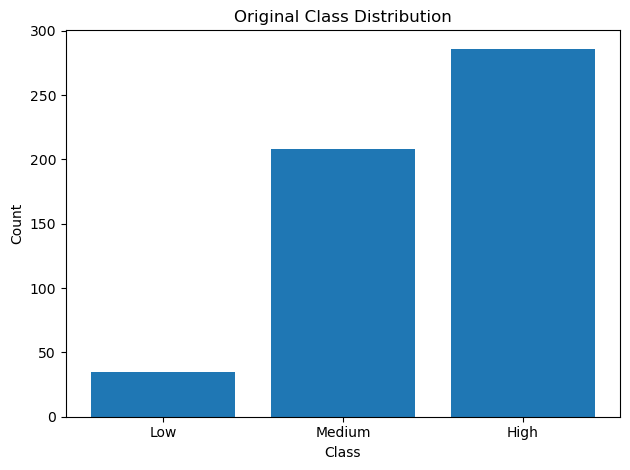

🧪 Test set saved. Train+Val: 449 | Test: 80
✅ Fold 0: Train=359 | Val=90
   ↪ Train class dist: {1: 141, 0: 24, 2: 194}
   ↪ Val class dist:   {2: 49, 1: 35, 0: 6}


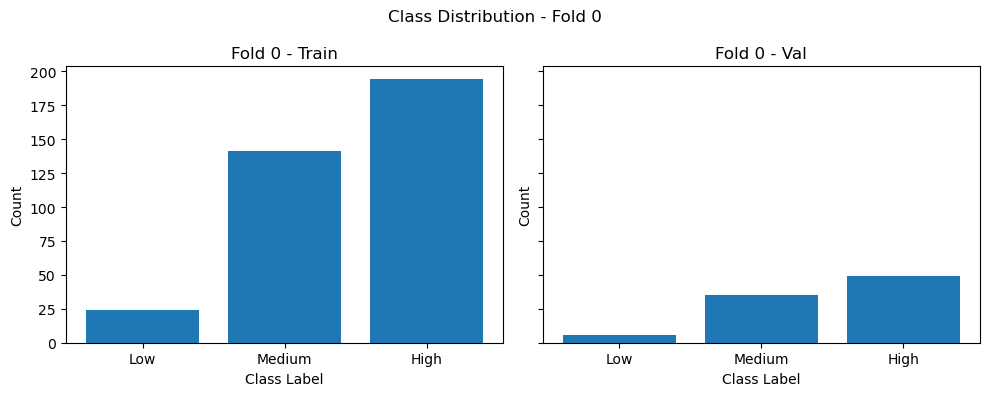

✅ Fold 1: Train=359 | Val=90
   ↪ Train class dist: {2: 194, 0: 24, 1: 141}
   ↪ Val class dist:   {1: 35, 2: 49, 0: 6}


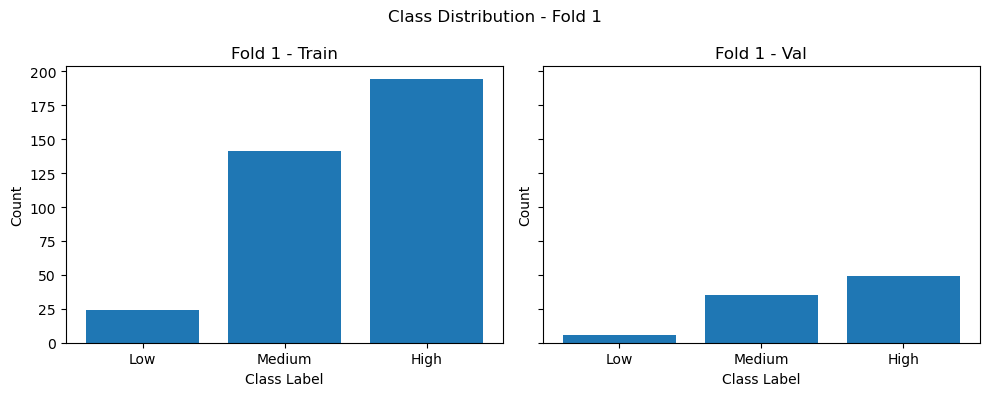

✅ Fold 2: Train=359 | Val=90
   ↪ Train class dist: {2: 194, 1: 141, 0: 24}
   ↪ Val class dist:   {2: 49, 1: 35, 0: 6}


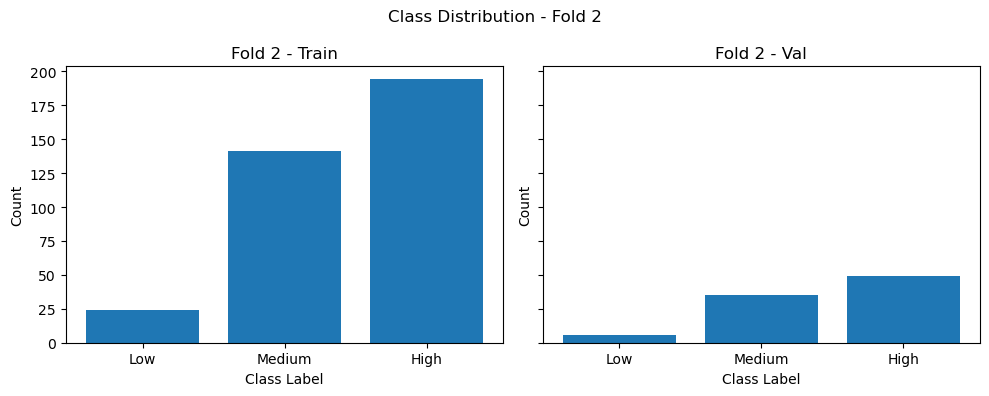

✅ Fold 3: Train=359 | Val=90
   ↪ Train class dist: {2: 195, 1: 140, 0: 24}
   ↪ Val class dist:   {2: 48, 1: 36, 0: 6}


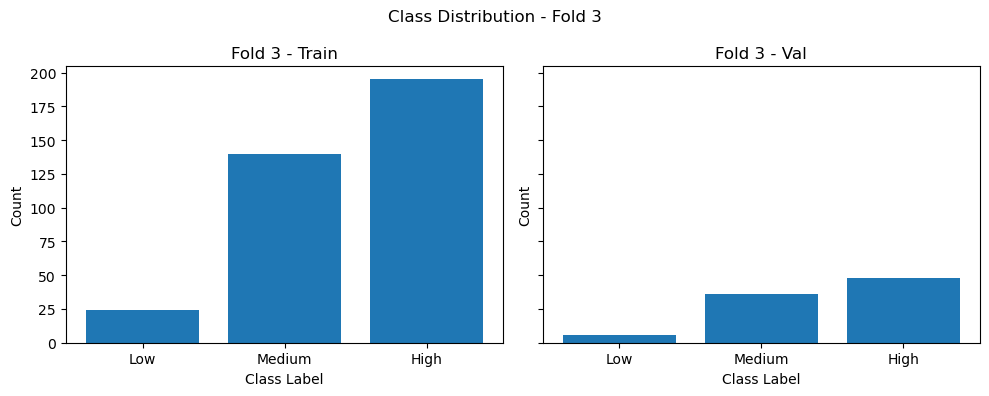

✅ Fold 4: Train=360 | Val=89
   ↪ Train class dist: {2: 195, 1: 141, 0: 24}
   ↪ Val class dist:   {0: 6, 2: 48, 1: 35}


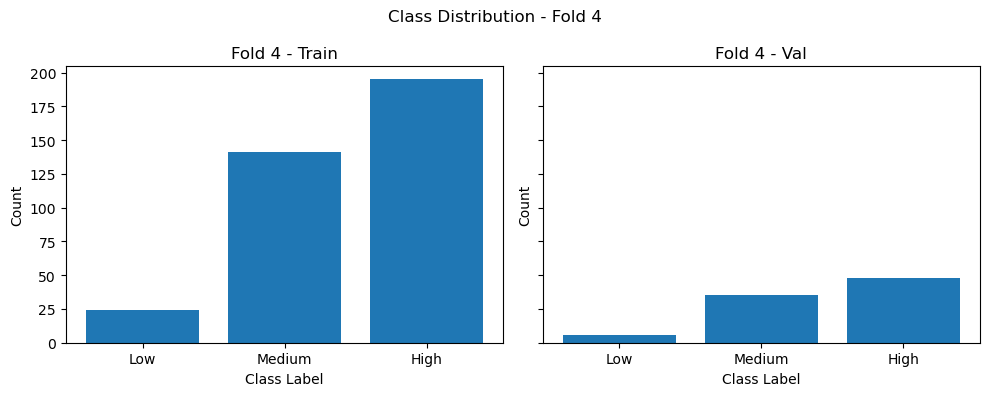

📁 Stratified 5-Fold CV + test split completed.


In [11]:
#Generate stratifiedKfold split dataset for classification task

import os
import torch
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from torch_geometric.data import Data

# --- Task ---
task = "classification"  # or "regression"
class_names = {0: "Low", 1: "Medium", 2: "High"}
class_order = [0, 1, 2]  #  plot in this order
# --- Paths ---
data_path = f"../3_graph_data/TRPM8_{task}_graph_dataset_v2.pt"
output_dir = f"../4_train_test_split/5fold_cv/{task}"
os.makedirs(output_dir, exist_ok=True)

# --- Load Dataset ---
dataset = torch.load(data_path)
print(f"📦 Total molecules: {len(dataset)}")

# --- Extract Labels for Stratification (classification only) ---
if task == "classification":
    labels = [int(data.y.item()) for data in dataset]
    label_counts = Counter(labels)
    print(f"🧾 Original class distribution: {dict(label_counts)}")

    # Plot original class distribution
    x_labels = [class_names[k] for k in class_order]
    y = [label_counts.get(k, 0) for k in class_order]
    plt.bar(x_labels, y)

    plt.xlabel("Class")

    plt.ylabel("Count")
    plt.title("Original Class Distribution")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "original_class_distribution.png"))
    plt.show()

# --- Train/Test Split ---
if task == "classification":
    trainval_data, test_data = train_test_split(
        dataset, test_size=0.15, random_state=42, stratify=labels
    )
else:
    trainval_data, test_data = train_test_split(
        dataset, test_size=0.15, random_state=42
    )

torch.save(test_data, os.path.join(output_dir, f"{task}_test.pt"))
print(f"🧪 Test set saved. Train+Val: {len(trainval_data)} | Test: {len(test_data)}")

# --- Prepare 5-Fold Cross-Validation ---
if task == "classification":
    trainval_labels = [int(data.y.item()) for data in trainval_data]
    splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    split_iterator = splitter.split(trainval_data, trainval_labels)
else:
    splitter = KFold(n_splits=5, shuffle=True, random_state=42)
    split_iterator = splitter.split(trainval_data)

# --- Save Splits and Plot Class Distributions ---
for fold, (train_idx, val_idx) in enumerate(split_iterator):
    train_set = [trainval_data[i] for i in train_idx]
    val_set = [trainval_data[i] for i in val_idx]

    torch.save(train_set, os.path.join(output_dir, f"{task}_train_fold{fold}.pt"))
    torch.save(val_set, os.path.join(output_dir, f"{task}_val_fold{fold}.pt"))

    print(f"✅ Fold {fold}: Train={len(train_set)} | Val={len(val_set)}")

    if task == "classification":
        train_labels = [int(data.y.item()) for data in train_set]
        val_labels = [int(data.y.item()) for data in val_set]

        train_counts = Counter(train_labels)
        val_counts = Counter(val_labels)

        print(f"   ↪ Train class dist: {dict(train_counts)}")
        print(f"   ↪ Val class dist:   {dict(val_counts)}")

        # Plot distributions
        fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
        x_train = list(train_counts.keys())
        y_train = list(train_counts.values())
        x_val = list(val_counts.keys())
        y_val = list(val_counts.values())
        # Consistent bar order
        train_y = [train_counts.get(k, 0) for k in class_order]
        val_y = [val_counts.get(k, 0) for k in class_order]
        x_labels = [class_names[k] for k in class_order]

        ax[0].bar(x_labels, train_y)
        ax[1].bar(x_labels, val_y)
        ax[0].set_title(f"Fold {fold} - Train")
        ax[1].set_title(f"Fold {fold} - Val")
        for a in ax:
            a.set_xlabel("Class Label")
            a.set_ylabel("Count")
        plt.suptitle(f"Class Distribution - Fold {fold}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"class_dist_fold{fold}.png"))
        plt.show()

print("📁 Stratified 5-Fold CV + test split completed.")


In [ ]:
#Generate Kfold split dataset for regression task

import os
import torch
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from torch_geometric.data import Data

# --- Task ---
task = "regression"  # or "regression"
#task = "classification"  # or "regression"
class_names = {0: "Low", 1: "Medium", 2: "High"}
class_order = [0, 1, 2]  #  plot in this order
# --- Paths ---
data_path = f"../3_graph_data/TRPM8_{task}_graph_dataset_v2.pt"
output_dir = f"../4_train_test_split/5fold_cv/{task}"
os.makedirs(output_dir, exist_ok=True)

# --- Load Dataset ---
dataset = torch.load(data_path)
print(f"📦 Total molecules: {len(dataset)}")

# --- Extract Labels for Stratification (classification only) ---
if task == "classification":
    labels = [int(data.y.item()) for data in dataset]
    label_counts = Counter(labels)
    print(f"🧾 Original class distribution: {dict(label_counts)}")

    # Plot original class distribution
    x_labels = [class_names[k] for k in class_order]
    y = [label_counts.get(k, 0) for k in class_order]
    plt.bar(x_labels, y)

    plt.xlabel("Class")

    plt.ylabel("Count")
    plt.title("Original Class Distribution")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "original_class_distribution.png"))
    plt.show()

# --- Train/Test Split ---
if task == "classification":
    trainval_data, test_data = train_test_split(
        dataset, test_size=0.15, random_state=42, stratify=labels
    )
else:
    trainval_data, test_data = train_test_split(
        dataset, test_size=0.15, random_state=42
    )

torch.save(test_data, os.path.join(output_dir, f"{task}_test.pt"))
print(f"🧪 Test set saved. Train+Val: {len(trainval_data)} | Test: {len(test_data)}")

# --- Prepare 5-Fold Cross-Validation ---
if task == "classification":
    trainval_labels = [int(data.y.item()) for data in trainval_data]
    splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    split_iterator = splitter.split(trainval_data, trainval_labels)
else:
    splitter = KFold(n_splits=5, shuffle=True, random_state=42)
    split_iterator = splitter.split(trainval_data)

# --- Save Splits and Plot Class Distributions ---
for fold, (train_idx, val_idx) in enumerate(split_iterator):
    train_set = [trainval_data[i] for i in train_idx]
    val_set = [trainval_data[i] for i in val_idx]

    torch.save(train_set, os.path.join(output_dir, f"{task}_train_fold{fold}.pt"))
    torch.save(val_set, os.path.join(output_dir, f"{task}_val_fold{fold}.pt"))

    print(f"✅ Fold {fold}: Train={len(train_set)} | Val={len(val_set)}")

    if task == "classification":
        train_labels = [int(data.y.item()) for data in train_set]
        val_labels = [int(data.y.item()) for data in val_set]

        train_counts = Counter(train_labels)
        val_counts = Counter(val_labels)

        print(f"   ↪ Train class dist: {dict(train_counts)}")
        print(f"   ↪ Val class dist:   {dict(val_counts)}")

        # Plot distributions
        fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
        x_train = list(train_counts.keys())
        y_train = list(train_counts.values())
        x_val = list(val_counts.keys())
        y_val = list(val_counts.values())
        # Consistent bar order
        train_y = [train_counts.get(k, 0) for k in class_order]
        val_y = [val_counts.get(k, 0) for k in class_order]
        x_labels = [class_names[k] for k in class_order]

        ax[0].bar(x_labels, train_y)
        ax[1].bar(x_labels, val_y)
        ax[0].set_title(f"Fold {fold} - Train")
        ax[1].set_title(f"Fold {fold} - Val")
        for a in ax:
            a.set_xlabel("Class Label")
            a.set_ylabel("Count")
        plt.suptitle(f"Class Distribution - Fold {fold}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"class_dist_fold{fold}.png"))
        plt.show()

print("📁 Stratified 5-Fold CV + test split completed.")


📦 Total molecules: 529
🧪 Test set saved. Train+Val: 449 | Test: 80
✅ Fold 0: Train=359 | Val=90
✅ Fold 1: Train=359 | Val=90
✅ Fold 2: Train=359 | Val=90
✅ Fold 3: Train=359 | Val=90
✅ Fold 4: Train=360 | Val=89
📁 Stratified 5-Fold CV + test split completed.


📦 Total molecules: 529
🧾 Original class distribution: {2: 286, 1: 208, 0: 35}


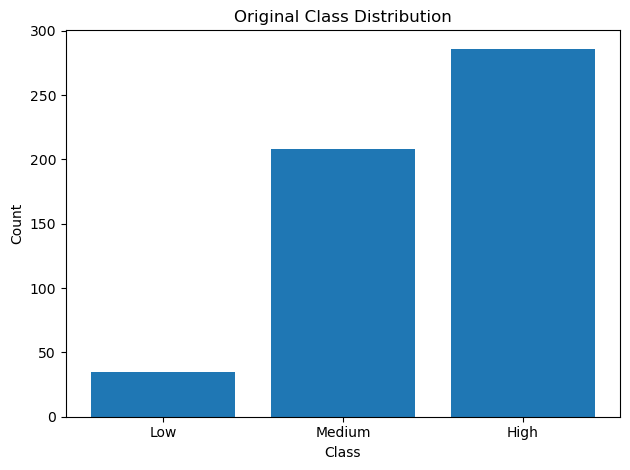

🧪 Test set saved. Train+Val: 476 | Test: 53
✅ Fold 0: Train=428 | Val=48
   ↪ Train class dist: {2: 231, 1: 168, 0: 29}
   ↪ Val class dist:   {2: 26, 1: 19, 0: 3}


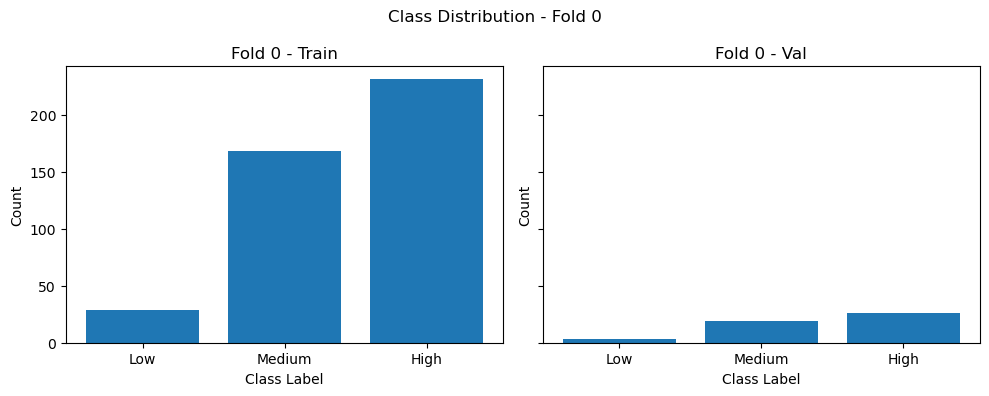

✅ Fold 1: Train=428 | Val=48
   ↪ Train class dist: {2: 231, 1: 168, 0: 29}
   ↪ Val class dist:   {0: 3, 2: 26, 1: 19}


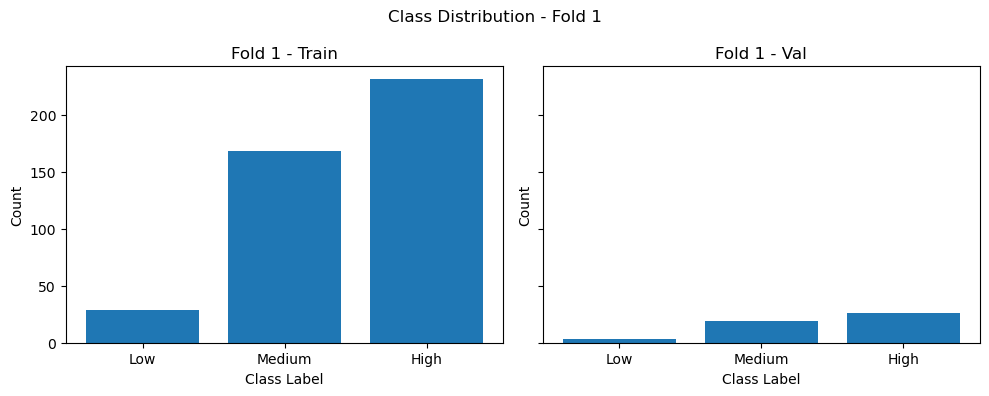

✅ Fold 2: Train=428 | Val=48
   ↪ Train class dist: {2: 231, 1: 168, 0: 29}
   ↪ Val class dist:   {0: 3, 1: 19, 2: 26}


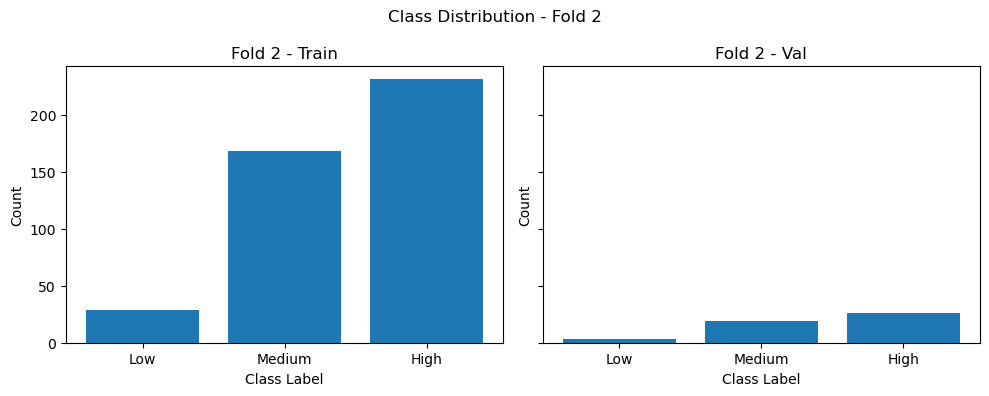

✅ Fold 3: Train=428 | Val=48
   ↪ Train class dist: {2: 231, 1: 168, 0: 29}
   ↪ Val class dist:   {1: 19, 2: 26, 0: 3}


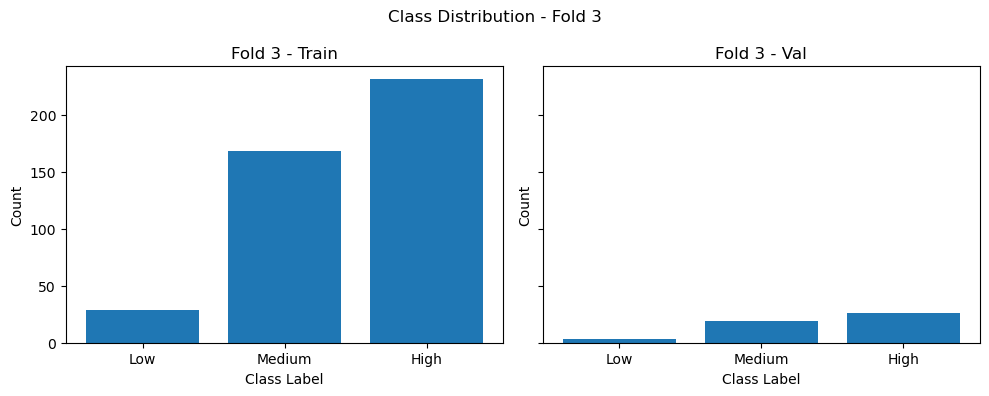

✅ Fold 4: Train=428 | Val=48
   ↪ Train class dist: {2: 231, 1: 169, 0: 28}
   ↪ Val class dist:   {2: 26, 1: 18, 0: 4}


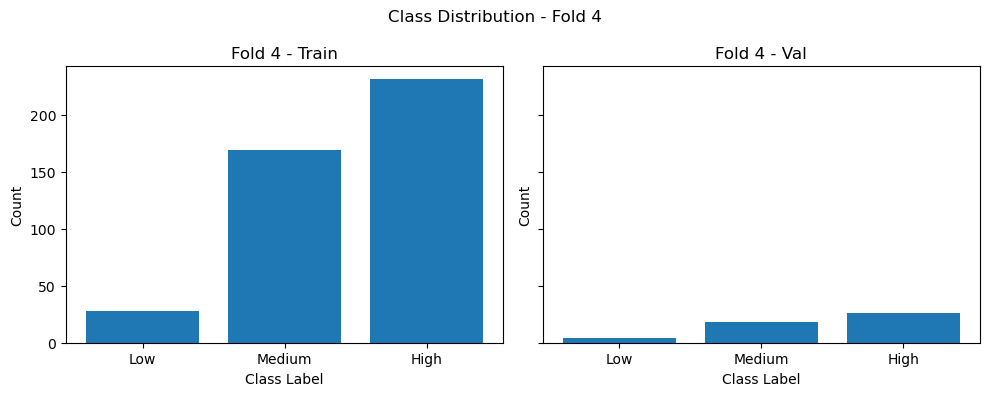

✅ Fold 5: Train=428 | Val=48
   ↪ Train class dist: {2: 231, 0: 28, 1: 169}
   ↪ Val class dist:   {1: 18, 2: 26, 0: 4}


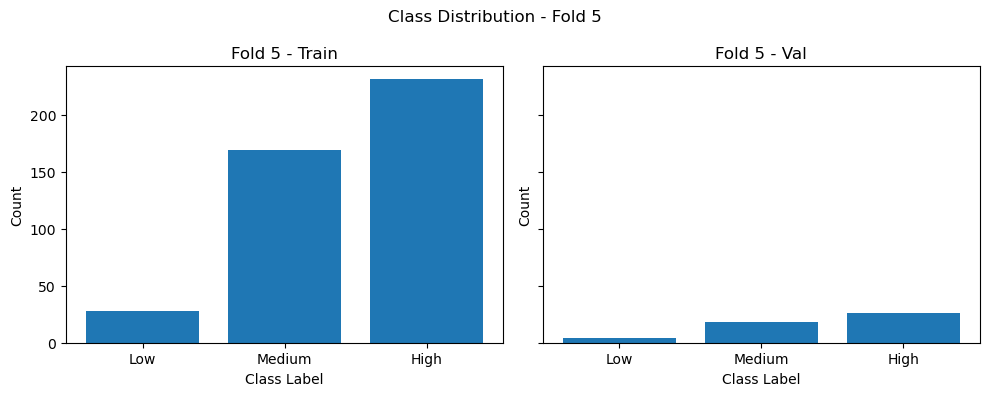

✅ Fold 6: Train=429 | Val=47
   ↪ Train class dist: {1: 169, 2: 231, 0: 29}
   ↪ Val class dist:   {2: 26, 1: 18, 0: 3}


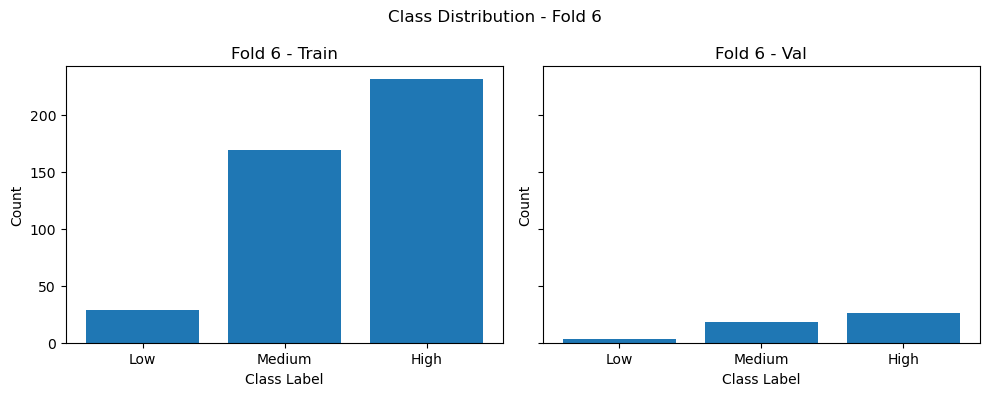

✅ Fold 7: Train=429 | Val=47
   ↪ Train class dist: {2: 232, 1: 168, 0: 29}
   ↪ Val class dist:   {2: 25, 1: 19, 0: 3}


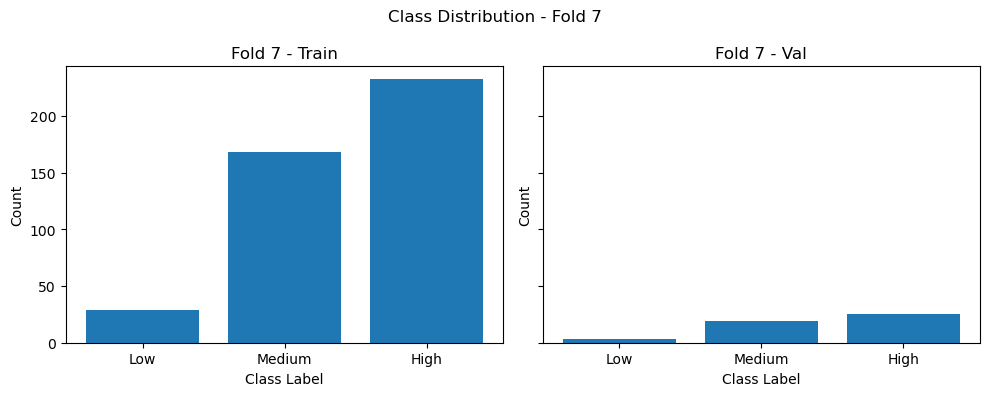

✅ Fold 8: Train=429 | Val=47
   ↪ Train class dist: {2: 232, 1: 168, 0: 29}
   ↪ Val class dist:   {1: 19, 2: 25, 0: 3}


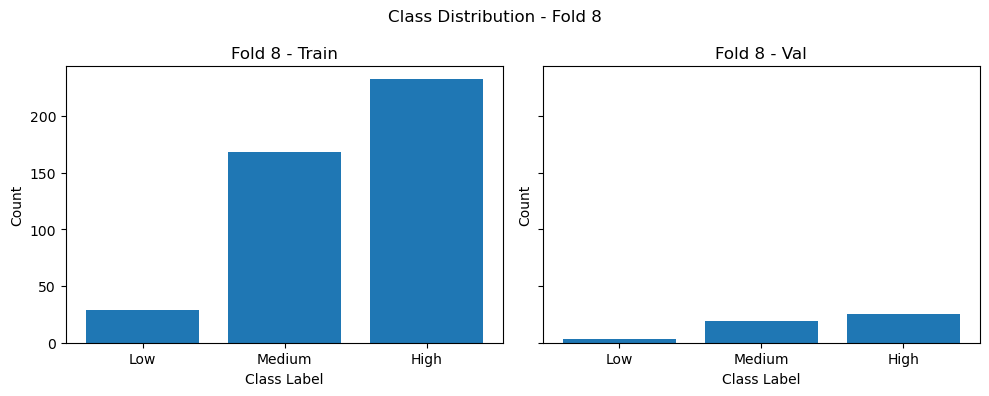

✅ Fold 9: Train=429 | Val=47
   ↪ Train class dist: {2: 232, 1: 168, 0: 29}
   ↪ Val class dist:   {1: 19, 2: 25, 0: 3}


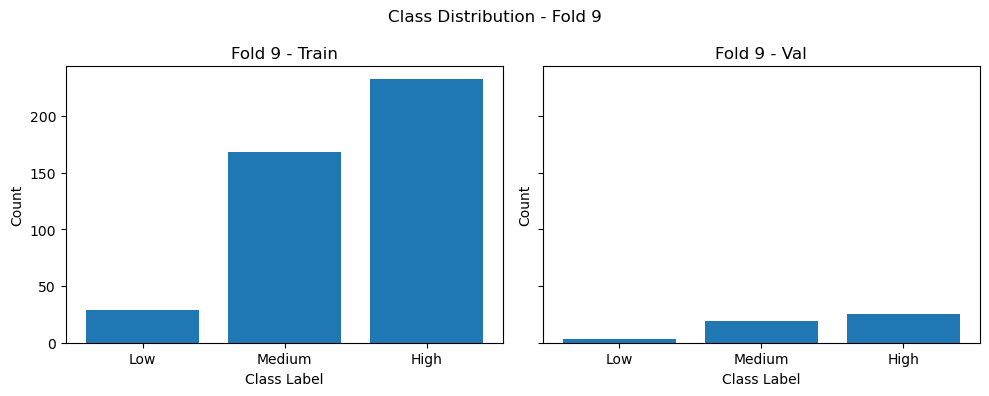

📁 Stratified 10-Fold CV + test split completed.


In [5]:
#Generate Kfold split dataset for regression task

import os
import torch
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from torch_geometric.data import Data

# --- Task ---
#task = "regression"  # or "regression"
task = "classification"  # or "regression"
class_names = {0: "Low", 1: "Medium", 2: "High"}
class_order = [0, 1, 2]  #  plot in this order
# --- Paths ---
data_path = f"../3_graph_data/TRPM8_{task}_graph_dataset_v2.pt"
output_dir = f"../4_train_test_split/10fold_cv/{task}"
os.makedirs(output_dir, exist_ok=True)

# --- Load Dataset ---
dataset = torch.load(data_path)
print(f"📦 Total molecules: {len(dataset)}")

# --- Extract Labels for Stratification (classification only) ---
if task == "classification":
    labels = [int(data.y.item()) for data in dataset]
    label_counts = Counter(labels)
    print(f"🧾 Original class distribution: {dict(label_counts)}")

    # Plot original class distribution
    x_labels = [class_names[k] for k in class_order]
    y = [label_counts.get(k, 0) for k in class_order]
    plt.bar(x_labels, y)

    plt.xlabel("Class")

    plt.ylabel("Count")
    plt.title("Original Class Distribution")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "original_class_distribution.png"))
    plt.show()

# --- Train/Test Split ---
if task == "classification":
    trainval_data, test_data = train_test_split(
        dataset, test_size=0.10, random_state=42, stratify=labels
    )
else:
    trainval_data, test_data = train_test_split(
        dataset, test_size=0.10, random_state=42
    )

torch.save(test_data, os.path.join(output_dir, f"{task}_test.pt"))
print(f"🧪 Test set saved. Train+Val: {len(trainval_data)} | Test: {len(test_data)}")

# --- Prepare 5-Fold Cross-Validation ---
if task == "classification":
    trainval_labels = [int(data.y.item()) for data in trainval_data]
    splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    split_iterator = splitter.split(trainval_data, trainval_labels)
else:
    splitter = KFold(n_splits=10, shuffle=True, random_state=42)
    split_iterator = splitter.split(trainval_data)

# --- Save Splits and Plot Class Distributions ---
for fold, (train_idx, val_idx) in enumerate(split_iterator):
    train_set = [trainval_data[i] for i in train_idx]
    val_set = [trainval_data[i] for i in val_idx]

    torch.save(train_set, os.path.join(output_dir, f"{task}_train_fold{fold}.pt"))
    torch.save(val_set, os.path.join(output_dir, f"{task}_val_fold{fold}.pt"))

    print(f"✅ Fold {fold}: Train={len(train_set)} | Val={len(val_set)}")

    if task == "classification":
        train_labels = [int(data.y.item()) for data in train_set]
        val_labels = [int(data.y.item()) for data in val_set]

        train_counts = Counter(train_labels)
        val_counts = Counter(val_labels)

        print(f"   ↪ Train class dist: {dict(train_counts)}")
        print(f"   ↪ Val class dist:   {dict(val_counts)}")

        # Plot distributions
        fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
        x_train = list(train_counts.keys())
        y_train = list(train_counts.values())
        x_val = list(val_counts.keys())
        y_val = list(val_counts.values())
        # Consistent bar order
        train_y = [train_counts.get(k, 0) for k in class_order]
        val_y = [val_counts.get(k, 0) for k in class_order]
        x_labels = [class_names[k] for k in class_order]

        ax[0].bar(x_labels, train_y)
        ax[1].bar(x_labels, val_y)
        ax[0].set_title(f"Fold {fold} - Train")
        ax[1].set_title(f"Fold {fold} - Val")
        for a in ax:
            a.set_xlabel("Class Label")
            a.set_ylabel("Count")
        plt.suptitle(f"Class Distribution - Fold {fold}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"class_dist_fold{fold}.png"))
        plt.show()

print("📁 Stratified 10-Fold CV + test split completed.")
